In [135]:
# IMPORTS
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy import ndimage
from skimage.feature import peak_local_max
from sklearn.cluster import DBSCAN

In [12]:
PATH = '../sequences/0'
imgs = []
for i in range(1, 5):
    imgs_path = []
    for image in glob(f'{PATH}{i}/*.tif'):
        img = cv2.imread(image, -1)
        imgs_path.append(cv2.normalize(img, dst=None, alpha=MIN, beta=MAX, norm_type=cv2.NORM_MINMAX))
    imgs.append(imgs_path)

In [91]:
MIN = 0
MAX = 2 ** 16 - 1
NROWS = imgs[0][0].shape[0]
NCOLS = imgs[0][0].shape[1]

In [176]:
def show(img, s=True):
    plt.imshow(img, cmap='gray')
    if s:
        plt.show()

## SEGMENTATION

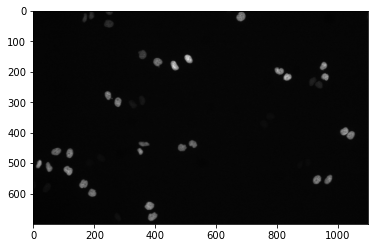

In [14]:
show(imgs[0][0])

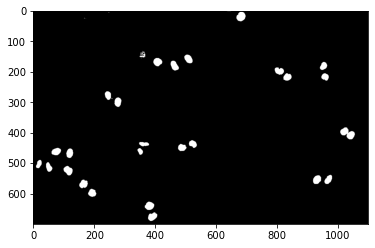

In [15]:
img = np.zeros_like(imgs[0][0])
cv2.threshold(imgs[0][0], dst=img, thresh=None, maxval=MAX, type=cv2.THRESH_OTSU)
show(img)

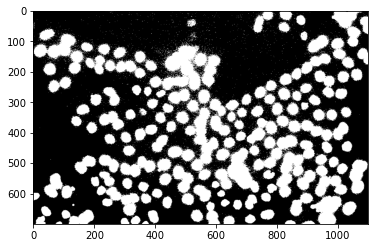

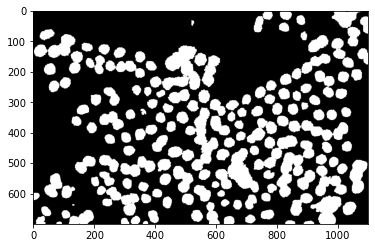

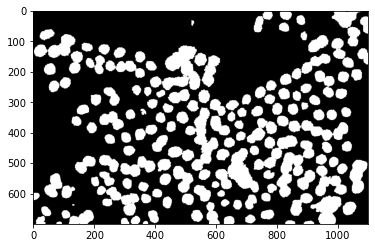

In [16]:
img = np.zeros_like(imgs[3][0])
cv2.threshold(imgs[3][-1], dst=img, thresh=np.median(imgs[3][-1])*1.2, maxval=MAX, type=cv2.THRESH_BINARY)
show(img)
struct_element = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(5,5))
img1 = np.zeros_like(imgs[3][0])
cv2.morphologyEx(img, dst=img1, op=cv2.MORPH_OPEN, kernel=struct_element, borderValue=cv2.BORDER_REFLECT)
show(img1)
img2 = np.zeros_like(imgs[3][0])
cv2.threshold(img1, dst=img2, thresh=MAX-1, maxval=MAX, type=cv2.THRESH_BINARY)
show(img2)

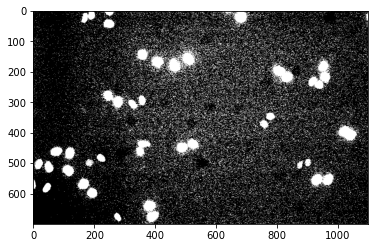

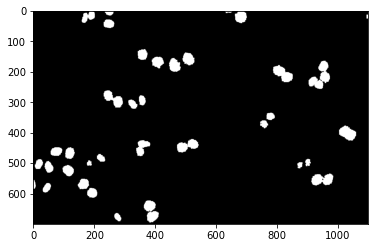

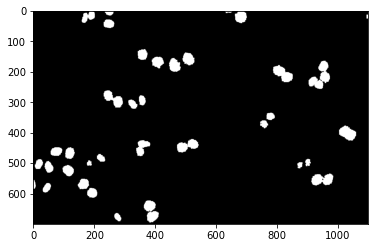

In [17]:
img = np.zeros_like(imgs[0][0])
cv2.threshold(imgs[0][0], dst=img, thresh=np.median(imgs[0][0])*1.2, maxval=MAX, type=cv2.THRESH_BINARY)
show(img)
struct_element = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(5,5))
img1 = np.zeros_like(imgs[0][0])
cv2.morphologyEx(img, dst=img1, op=cv2.MORPH_OPEN, kernel=struct_element, borderValue=cv2.BORDER_REFLECT)
show(img1)
img3 = np.zeros_like(imgs[0][0])
cv2.threshold(img1, dst=img3, thresh=MAX-1, maxval=MAX, type=cv2.THRESH_BINARY)
show(img3)

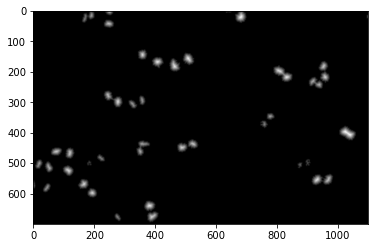

In [18]:
dt = ndimage.distance_transform_edt(img3)
show(dt)

In [19]:
coords = peak_local_max(dt, min_distance=4, labels=img3)
coords.shape

(57, 2)

In [45]:
def points(img):
    pts = {}
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] == MAX:
                pts[(i,j)] = None
    return pts

## EROSION: to find centroids

In [21]:
pts1 = points(img3)

In [43]:
def is_last(pt, pts):
    for i in range(-1,2):
        for j in range(-1,2):
            if i == j and i == 0:
                continue
            if (pt[0]+i, pt[1]+j) in pts:
                return False
    return True

In [23]:
def eroded(pts):
    new1 = pts.copy()
    for pt in pts.keys():
        if (pt[0], pt[1]-1) in pts and (pt[0], pt[1]+1) in pts:
            continue
        elif is_last(pt, new1) and num_connected(pt, pts, new1, {}) == 1:
        #elif num_connected(pt, pts, new1, {}) == 1:
            new1[pt] = None
        else:
            del new1[pt]
    new2 = new1.copy()
    for pt in new1.keys():
        if (pt[0]-1, pt[1]) in new1 and (pt[0]+1, pt[1]) in new1:
            continue
        elif is_last(pt, new2) and num_connected(pt, new1, new2, {}) == 1:
        #elif num_connected(pt, new1, new2, {}) == 1:
            new2[pt] = None
        else:
            del new2[pt]
    '''
    new1 = {}
    # pass with S = 1x3 filter
    for pt in pts.keys():
        if (pt[0], pt[1]-1) in pts and (pt[0], pt[1]+1) in pts:
            new1[pt] = None
        elif is_last(pt, new1):
            new1[pt] = None
        #elif (pt[0], pt[1]-1) not in pts and (pt[0], pt[1]+1) not in pts and is_last(pt, pts):
            #new1[pt] = None
    new2 = {}
    # pass with S = 3x1 filter
    for pt in new1.keys():
        if (pt[0]-1, pt[1]) in new1 and (pt[0]+1, pt[1]) in new1:
            new2[pt] = None
        elif is_last(pt, new2):
            new2[pt] = None
        #elif (pt[0]-1, pt[1]) not in new1 and (pt[0]+1, pt[1]) not in new1 and is_last(pt, new1):
            #new2[pt] = None
    '''
    return new2

In [24]:
pts2 = eroded(pts1)

In [25]:
len(pts1)

35462

In [26]:
len(pts2)

29898

In [115]:
def create_img(pts):
    new = np.zeros((NROWS, NCOLS))
    for (i, j) in pts:
        new[i, j] = MAX
    return new


In [28]:
imgz = create_img(pts2)

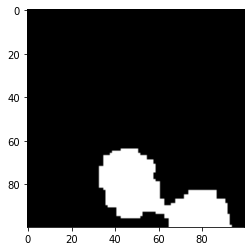

In [29]:
show(imgz[200:300,200:300])

In [35]:
# BFS search of connected components, count number in new points dict
def num_connected(pt, old_pts, new_pts, already):
    already[(pt[0],pt[1])] = None
    count = 0
    #print(pt)
    #print(already)
    for i in range(-1, 2):
        for j in range(-1, 2):
            if (pt[0]+i,pt[1]+j) not in old_pts or (pt[0]+i,pt[1]+j) in already:
                continue
            already[(pt[0],pt[1])] = None
            count += num_connected((pt[0]+i,pt[1]+j), old_pts, new_pts, already)
    if (pt[0], pt[1]) in new_pts:
        count += 1
    return count
       

In [117]:
def centroids(img):
    pts = points(img)
    num = 0
    while 1:
        num += 1
        pts_before = pts.copy()
        pts = eroded(pts)
        show(create_img(pts)[0:50,100:200])
        #show(create_img(pts))
        if pts == pts_before:
            print(num)
            return pts

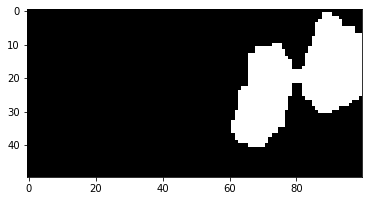

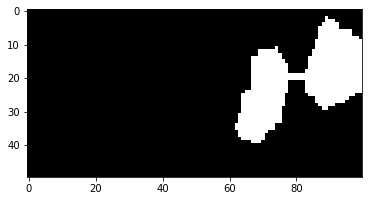

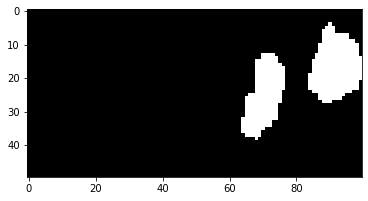

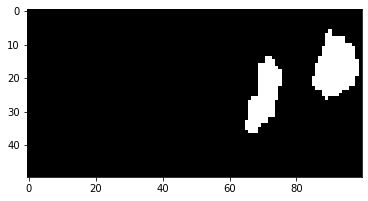

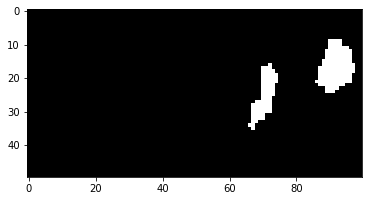

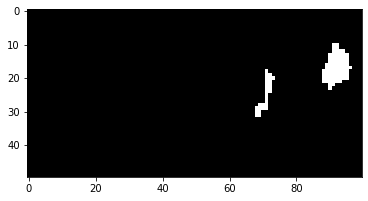

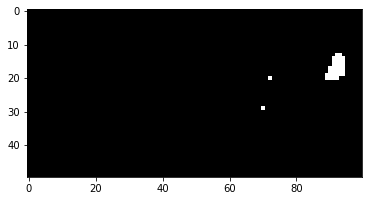

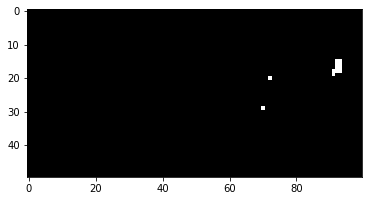

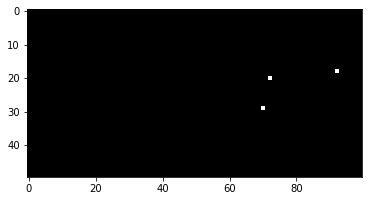

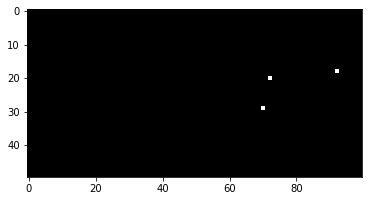

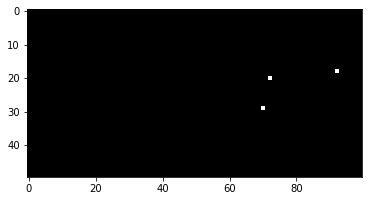

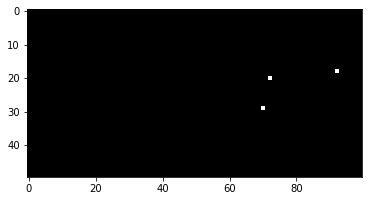

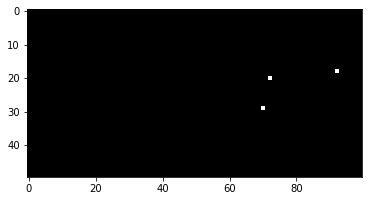

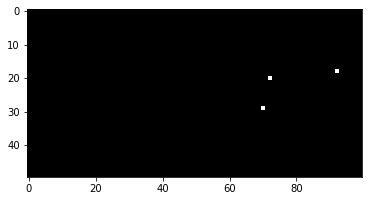

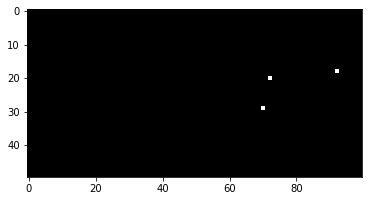

15


In [44]:
pts_final = centroids(img3)

In [38]:
len(pts_final)

70

#### shows promise if cells are not joined, try later with suboptimal threshold that gives all regularly unjoined cells in img as unjoined in thresholded if possible, try points with kMeansClustering

## Erase Border Cells

In [121]:
def DFS(pt, pts, connect):
    connect[pt] = None
    x, y = pt
    for i in range(-1, 2):
        for j in range(-1, 2):
            if (x+i,j+y) in pts and (x+i,j+y) not in connect:
                DFS((x+i,j+y), pts, connect)
    return connect

In [129]:
def flush_border(pts):
    new = pts.copy()
    delete = {}
    for pt in pts:
        edge = pt[1] == 0 or pt[1] == NCOLS-1 or pt[0] == 0 or pt[0] == NROWS-1
        if edge and pt not in delete:
            connect = DFS(pt, pts, {})
            for pt in connect:
                delete[pt] = None
    for pt in delete.keys():
        del new[pt]
    return new

In [131]:
pts = points(img3)
new = flush_border(pts)

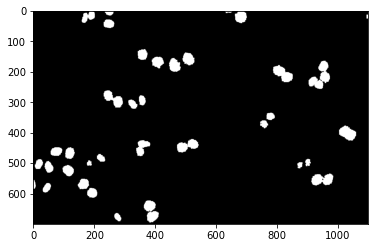

In [133]:
show(create_img(pts))

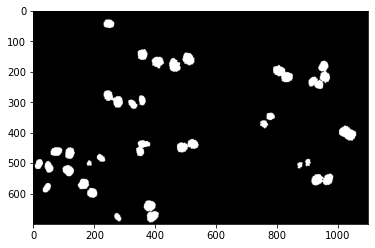

In [132]:
show(create_img(new))

## Cluster: to find centroids

In [152]:
pts = np.array([list(pt) for pt in flush_border(points(img3))])
cluster = DBSCAN(eps=1.5, min_samples=1).fit(pts)
print(cluster.labels_)
print(np.unique(cluster.labels_))

[ 0  0  0 ... 29 29 29]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


In [172]:
def show_point_lables(pts, labels):
    pass

In [163]:
def get_centroids(img):
    pts = np.array([list(pt) for pt in flush_border(points(img))])
    cluster = DBSCAN(eps=1.5, min_samples=1).fit(pts)
    extrema = {}
    for i, label in enumerate(cluster.labels_):
        if label == -1:
            continue
        if label not in extrema:
            extrema[label] = {'x1': pts[i][0], 'x2': pts[i][0],
                              'y1': pts[i][1], 'y2': pts[i][1]}
            continue
        if pts[i][0] < extrema[label]['x1']:
            extrema[label]['x1'] = pts[i][0]
        elif pts[i][0] > extrema[label]['x2']:
            extrema[label]['x2'] = pts[i][0]
        if pts[i][1] < extrema[label]['y1']:
            extrema[label]['y1'] = pts[i][1]
        elif pts[i][1] > extrema[label]['y2']:
            extrema[label]['y2'] = pts[i][1]
    centroids = {}
    for label in extrema.keys():
        ext = extrema[label]
        centroids[label] = (int((ext['x1'] + ext['x2']) / 2), 
                            int((ext['y1'] + ext['y2']) / 2))
    return centroids

In [167]:
cs = get_centroids(img3)

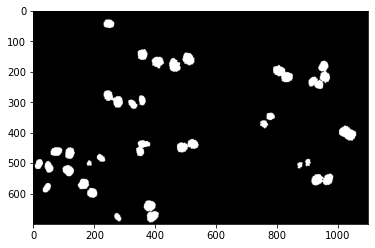

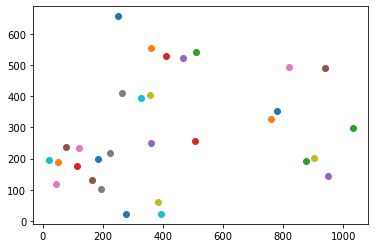

In [184]:
show(create_img(flush_border(pts)))
for (x, y) in cs.values():
    plt.scatter(y, NROWS-x)
plt.show()

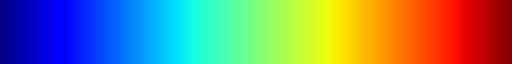

In [70]:
from matplotlib import cm
cmap = cm.get_cmap('jet')
cmap